In [1]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
import requests

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import torch
from torch import nn  
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from kmodes.kprototypes import KPrototypes
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro


from bertopic import BERTopic

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = 'https://www.bibliotechediroma.it/sebina/repository/opendata/COMMENTI_UTE/202209/COMMENTI_UTE_01.json'

r = requests.get(url)

df = json_normalize(r.json(), record_path =['tabella'])

df.head(3)

Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0                           4          138                 4.0000   
1                        None         3567                   None   
2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

  Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0          31    STUDENTE                  1990  00148  Libro moderno   
1          33    STUDENTE                  1982  04011  Libro moderno   
2          33    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23  
1                              Testi rari e preziosi    2018/08/28  
2                   "Genuflesse finanche le parole"     2018/08/31

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18905 entries, 0 to 18904
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Punteggio utente sul titolo  813 non-null    object
 1   Id. commento                 18905 non-null  object
 2   Punteggio medio titolo       1216 non-null   object
 3   Cod. tipo materiale          18905 non-null  object
 4   Tipo documento               18905 non-null  object
 5   Identificativo titolo        18905 non-null  object
 6   Eta' utente                  18822 non-null  object
 7   Tipo utente                  18905 non-null  object
 8   Anno di pubblicazione        18819 non-null  object
 9   CAP                          18905 non-null  object
 10  Tipo materiale               18902 non-null  object
 11  Lingua 3                     18905 non-null  object
 12  Lingua 2                     18905 non-null  object
 13  Natura                       18

In [4]:
# Notably, a column from the dataset collects a score given by the user to the product, from 1 to 5. Nevertheless, out of the 15636 total reviews, only 5.2% display this score, therefore this information will not be used:

no_scores = df['Punteggio utente sul titolo'].isna().sum()

print("Total reviews: ", df.shape[0])
print("No scores given: ", no_scores)
print("Perc. of given scores: ", str(round((1-no_scores/df.shape[0])*100,2))+'%' )

Total reviews:  18905
No scores given:  18092
Perc. of given scores:  4.3%


In [5]:
df['Tipo materiale'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Tipo materiale
Libro moderno          79.94%
Audiovisivo             11.6%
Risorsa elettronica     8.44%
Musica                  0.01%
Name: proportion, dtype: object

Null ages:  0


count    18905.000000
mean        49.850198
std         15.831696
min          0.000000
25%         39.000000
50%         51.000000
75%         63.000000
max         94.000000
Name: Eta' utente, dtype: float64

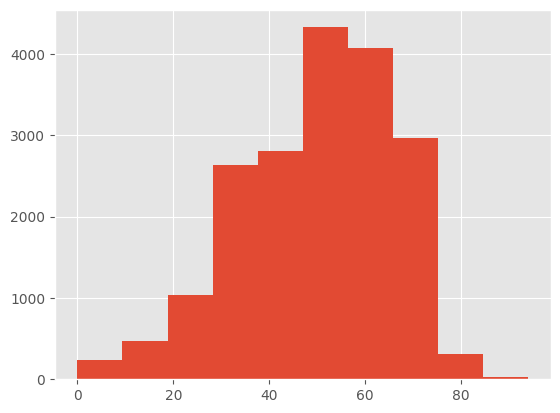

In [6]:
df["Eta' utente"] = df["Eta' utente"].fillna(0).astype(int)

df["Eta' utente"].hist()
print("Null ages: ", df["Eta' utente"].isna().sum())
df["Eta' utente"].describe()

In [7]:
df['Tipo utente'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Tipo utente
IMPIEGATO                         32.02%
STUDENTE                          19.29%
IMPRENDITORE E LIBERO PROFESS.    12.75%
RITIRATO DAL LAVORO               10.92%
ALTRI LAVORATORI DIPENDENTI        5.73%
NON OCCUPATO                       5.71%
CASALINGA                          5.19%
LAVORATORE AUTONOMO E COADIUV.     3.39%
DIRIGENTE                          2.97%
ALTRE CATEGORIE NON PROFESSION     0.78%
INSEGNANTE                         0.52%
BIBLIOTECA SOL                     0.43%
OPERAIO                            0.28%
BIBLIOTECARIO SOL                  0.01%
Name: proportion, dtype: object

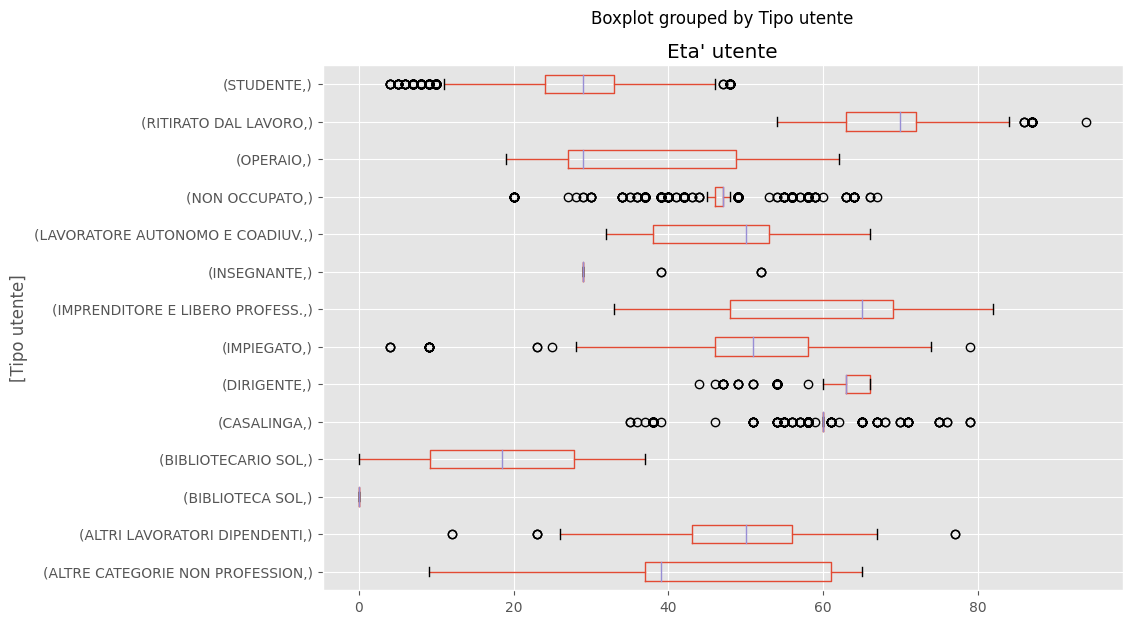

In [8]:
boxplot = df.boxplot(column=["Eta' utente"], by=["Tipo utente"], figsize=(10,7), vert=False)

In [9]:
# BERTopic requires a list as input
comments = df['Descrizione commento'].tolist()
comments[:3]

['Libro consigliato a tutti coloro che vogliono o devono analizzare la prima raccolta di Ungaretti.\nIl commento ad ogni poesia è fin troppo esaustivo.\nLa pecca probabilmente è nel linguaggio esageratamente forbito di Ossola.\nUso insistito di parole complesse e poco conosciuto; citazione in francesce senza la traduzione (non tutti sanno capire il francese), uso volutissimo del latino: hit e nunc, editio princeps, omoioteleutos e così via. ogni tanto bisogna fermarsi e cercare il significato di certe parole, altrimenti la lettura è molto complessa.',
 "Un volumetto davvero prezioso che raccoglie epistole e poesie di una personalità cruciale del panorama artistico italiano degli anni '20. Coinvolgente la prefazione di Amelia Rosselli che considerò sempre Scipione un grandissimo poeta, benché nella sua purtroppo breve parabola artistica non avesse composto più di una diecina di poesie. Nelle composizioni di Scipione l'uomo, quasi primitivo, è in un dialogo costante con la terra e le sue

In [10]:
# {Maarten Grootendorst} https://github.com/MaartenGr/BERTopic
# BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. It even supports visualizations similar to LDAvis!

topic_model = BERTopic(language="italian", calculate_probabilities=True, verbose=True)
topic_model


In [11]:
topics, probs = topic_model.fit_transform(comments)

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [00:31<00:00, 18.59it/s]
2023-11-02 13:48:00,627 - BERTopic - Transformed documents to Embeddings
2023-11-02 13:48:36,048 - BERTopic - Reduced dimensionality
2023-11-02 13:49:02,767 - BERTopic - Clustered reduced embeddings


In [12]:
unique_topics = set(topics)
len(unique_topics)

159

In [13]:
[(topics[i], probs[i]) for i in range(2)]

[(130,
  array([0.0032792 , 0.00554656, 0.00368316, 0.00334818, 0.00529824,
         0.00307592, 0.00396573, 0.00214881, 0.00441487, 0.00400123,
         0.0048439 , 0.00439814, 0.01059335, 0.00441368, 0.01298588,
         0.00471078, 0.00392833, 0.0020896 , 0.00468207, 0.00317326,
         0.0057096 , 0.00439544, 0.00485456, 0.00506638, 0.02299822,
         0.00506908, 0.00315347, 0.0083525 , 0.0038047 , 0.00523014,
         0.00416656, 0.00457812, 0.00383338, 0.00903742, 0.01692848,
         0.00481524, 0.01300279, 0.00338169, 0.00568896, 0.00309285,
         0.00448622, 0.00396973, 0.00582233, 0.00568612, 0.00370254,
         0.00468238, 0.00301396, 0.00527001, 0.00266231, 0.00650671,
         0.00212693, 0.00538486, 0.00442297, 0.00398227, 0.00392641,
         0.00636466, 0.00258884, 0.00543431, 0.00372393, 0.00398301,
         0.00333312, 0.01390608, 0.00491335, 0.00575224, 0.00284161,
         0.00649699, 0.00356573, 0.00505033, 0.01129946, 0.00463849,
         0.00406225, 0.0032

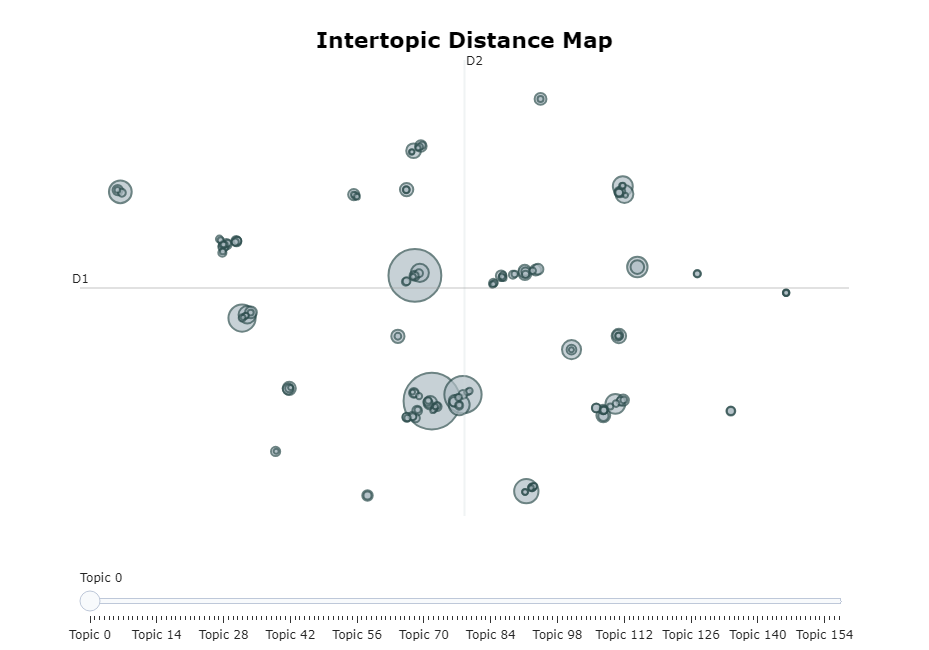

In [14]:
# import nbformat
# print(nbformat.__version__)

topic_model.visualize_topics()

In [15]:
topics_pivot = topic_model.get_topic_info()
topics_pivot


Topic  Count                                    Name  \
0       -1  10251                         -1_di_che_la_un   
1        0   1255                0_film_regista_un_attori   
2        1   1096                     1_mi_libro_ho_libri   
3        2    545         2_bambini_libro_disegni_bambino   
4        3    290              3_donne_donna_femminile_le   
..     ...    ...                                     ...   
154    153     10       153_venezia_città_veneziano_acqua   
155    154     10        154_destino_lajos_ester_scappare   
156    155     10         155_guerra_soldati_nemico_paura   
157    156     10       156_florio_sicilia_franca_bagnara   
158    157     10  157_shopping_kinsella_bloomwood_sophie   

                                        Representation  \
0         [di, che, la, un, il, in, una, non, per, si]   
1    [film, regista, un, attori, del, il, da, che, ...   
2    [mi, libro, ho, libri, questo, non, letto, mol...   
3    [bambini, libro, disegni, bambino, adatto, ai,...   
4    [donne, donna, femminile, le, loro, uomini, un...   
..                                                 ...   
154  [venezia, città, veneziano, acqua, inondazione...   
155  [destino, lajos, ester, scappare, grace, trova...   
156  [guerra, soldati, nemico, paura, trincea, gent...   
157  [florio, sicilia, franca, bagnara, auci, giuli...   
158  [shopping, kinsella, bloomwood, sophie, love, ...   

                                   Representative_Docs  
0    [La scrittura capace di trasformare una storia...  
1    [Oggi si direbbe " film con un cast stellare" ...  
2    [Mi trovo a scrivere una recensione abbastanza...  
3    [Molto bello, lo consiglio. Secondo me è adatt...  
4    [romanzo sulle donne che hanno scritto le stor...  
..                                                 ...  
154  [Un veneziano eccellente racconta la sua Venez...  
155  [Dei "Promessi sposi", letto al liceo (dove in...  
156  [La guerra, dimentichiamo che la guerra non è ...  
157  [Le siciliane di Gaetano Savatteri\nLa Sicilia...  
158  [Ho conosciuto Sophie Kinsella con la saga di ...  

[159 rows x 5 columns]

In [16]:
events_count = topics_pivot['Count'].sum()
events_count


18905

In [17]:
def calc_perc(row):
  return round(row['Count']*100/events_count, 2)

topics_pivot['Perc'] = topics_pivot.apply (lambda row: calc_perc(row), axis=1)
topics_pivot

Topic  Count                                    Name  \
0       -1  10251                         -1_di_che_la_un   
1        0   1255                0_film_regista_un_attori   
2        1   1096                     1_mi_libro_ho_libri   
3        2    545         2_bambini_libro_disegni_bambino   
4        3    290              3_donne_donna_femminile_le   
..     ...    ...                                     ...   
154    153     10       153_venezia_città_veneziano_acqua   
155    154     10        154_destino_lajos_ester_scappare   
156    155     10         155_guerra_soldati_nemico_paura   
157    156     10       156_florio_sicilia_franca_bagnara   
158    157     10  157_shopping_kinsella_bloomwood_sophie   

                                        Representation  \
0         [di, che, la, un, il, in, una, non, per, si]   
1    [film, regista, un, attori, del, il, da, che, ...   
2    [mi, libro, ho, libri, questo, non, letto, mol...   
3    [bambini, libro, disegni, bambino, adatto, ai,...   
4    [donne, donna, femminile, le, loro, uomini, un...   
..                                                 ...   
154  [venezia, città, veneziano, acqua, inondazione...   
155  [destino, lajos, ester, scappare, grace, trova...   
156  [guerra, soldati, nemico, paura, trincea, gent...   
157  [florio, sicilia, franca, bagnara, auci, giuli...   
158  [shopping, kinsella, bloomwood, sophie, love, ...   

                                   Representative_Docs   Perc  
0    [La scrittura capace di trasformare una storia...  54.22  
1    [Oggi si direbbe " film con un cast stellare" ...   6.64  
2    [Mi trovo a scrivere una recensione abbastanza...   5.80  
3    [Molto bello, lo consiglio. Secondo me è adatt...   2.88  
4    [romanzo sulle donne che hanno scritto le stor...   1.53  
..                                                 ...    ...  
154  [Un veneziano eccellente racconta la sua Venez...   0.05  
155  [Dei "Promessi sposi", letto al liceo (dove in...   0.05  
156  [La guerra, dimentichiamo che la guerra non è ...   0.05  
157  [Le siciliane di Gaetano Savatteri\nLa Sicilia...   0.05  
158  [Ho conosciuto Sophie Kinsella con la saga di ...   0.05  

[159 rows x 6 columns]

In [18]:
# we observe the first 25 topics
top_topics = 25

topics_pivot.head(top_topics).drop([0])

Topic  Count                                      Name  \
1       0   1255                  0_film_regista_un_attori   
2       1   1096                       1_mi_libro_ho_libri   
3       2    545           2_bambini_libro_disegni_bambino   
4       3    290                3_donne_donna_femminile_le   
5       4    232             4_commissario_omicidio_il_una   
6       5    203     5_bello_bellissimo_molto_interessante   
7       6    171                    6_amore_storia_due_che   
8       7    164    7_giapponese_giappone_giapponesi_tokyo   
9       8    156                8_russia_russa_russi_russo   
10      9    153                     9_lei_padre_madre_una   
11     10    143           10_hitler_nazista_nazisti_ebrei   
12     11    128   11_leggere_lettura_piacevole_ombrellone   
13     12    125               12_roma_città_romana_romani   
14     13    118                     13_alice_anna_una_lei   
15     14     85        14_italiano_italia_napoli_italiana   
16     15     82      15_economia_economica_politica_delle   
17     16     76          16_palestinese_arabo_pag_israele   
18     17     73                17_cinese_cina_chen_cinesi   
19     18     72       18_thriller_finale_trama_personaggi   
20     19     70           19_brani_bach_ascolto_orchestra   
21     20     69  20_fisica_matematica_scienza_quantistica   
22     21     69           21_piante_alberi_vegetale_bosco   
23     22     68                 22_felicità_morte_vita_ci   
24     23     64          23_lingua_inglese_esercizi_utile   

                                       Representation  \
1   [film, regista, un, attori, del, il, da, che, ...   
2   [mi, libro, ho, libri, questo, non, letto, mol...   
3   [bambini, libro, disegni, bambino, adatto, ai,...   
4   [donne, donna, femminile, le, loro, uomini, un...   
5   [commissario, omicidio, il, una, di, del, inda...   
6   [bello, bellissimo, molto, interessante, consi...   
7   [amore, storia, due, che, una, un, donna, si, ...   
8   [giapponese, giappone, giapponesi, tokyo, paes...   
9   [russia, russa, russi, russo, dostoevskij, di,...   
10  [lei, padre, madre, una, sua, la, suo, ha, cas...   
11  [hitler, nazista, nazisti, ebrei, germania, te...   
12  [leggere, lettura, piacevole, ombrellone, da, ...   
13  [roma, città, romana, romani, del, capitale, d...   
14  [alice, anna, una, lei, donna, sua, la, person...   
15  [italiano, italia, napoli, italiana, storia, s...   
16  [economia, economica, politica, delle, del, le...   
17  [palestinese, arabo, pag, israele, palestina, ...   
18  [cinese, cina, chen, cinesi, cao, partito, cul...   
19  [thriller, finale, trama, personaggi, episodio...   
20  [brani, bach, ascolto, orchestra, musica, comp...   
21  [fisica, matematica, scienza, quantistica, teo...   
22  [piante, alberi, vegetale, bosco, mancuso, viv...   
23  [felicità, morte, vita, ci, gioia, propria, la...   
24  [lingua, inglese, esercizi, utile, imparare, t...   

                                  Representative_Docs  Perc  
1   [Oggi si direbbe " film con un cast stellare" ...  6.64  
2   [Mi trovo a scrivere una recensione abbastanza...  5.80  
3   [Molto bello, lo consiglio. Secondo me è adatt...  2.88  
4   [romanzo sulle donne che hanno scritto le stor...  1.53  
5   [In questo nuovo episodio, il commissario dovr...  1.23  
6   [Molto bello., Molto bello , Molto bello e int...  1.07  
7   [Breve racconto autobiografico di un grande, i...  0.90  
8   [Il Giappone è una realtà estremamente comples...  0.87  
9   [Questo libro, che l'estroso Paolo Nori non co...  0.83  
10  [Confinata nel cuore del deserto di pietra, Ma...  0.81  
11  [Un romanzo di restituzione, restituzione di u...  0.76  
12  [Da leggere!, Da leggere, scorrevole e ben scr...  0.68  
13  [Per gli abitanti di Monteverde, ma anche chi ...  0.66  
14  [Nel panorama di una campagna inglese, scossa ...  0.62  
15  [Cosa scrivere di un romanzo divenuto un best ...  0.45  
16  [A chi fanno comodo i poveri? C

In [19]:
# we use np.linspace(0, 1, top_topics) instead of a simple range like range(0, top_topics) is because color maps in Matplotlib, such as plt.cm.rainbow, expect input values in the range [0, 1]. These input values are then mapped to colors in the color map

colors = plt.cm.rainbow(np.linspace(0, 1, top_topics))
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.21568627e-01, 1.22888291e-01, 9.98103329e-01, 1.00000000e+00],
       [3.35294118e-01, 2.55842778e-01, 9.91644696e-01, 1.00000000e+00],
       [2.49019608e-01, 3.84105749e-01, 9.80634770e-01, 1.00000000e+00],
       [1.70588235e-01, 4.94655843e-01, 9.66718404e-01, 1.00000000e+00],
       [8.43137255e-02, 6.07538946e-01, 9.47177357e-01, 1.00000000e+00],
       [1.96078431e-03, 7.09281308e-01, 9.23289106e-01, 1.00000000e+00],
       [8.03921569e-02, 7.90532412e-01, 8.97892032e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [2.52941176e-01, 9.25637660e-01, 8.30184031e-01, 1.00000000e+00],
       [3.31372549e-01, 9.65124085e-01, 7.94289890e-01, 1.00000000e+00],
       [4.17647059e-01, 9.91644696e-01, 7.51331890e-01, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [5.82352941e-01, 9.91644696e-01, 6.59924535e

In [20]:
# iterator that you can loop over to access each color in the colors list one at a time

iter_color = iter(colors)
iter_color


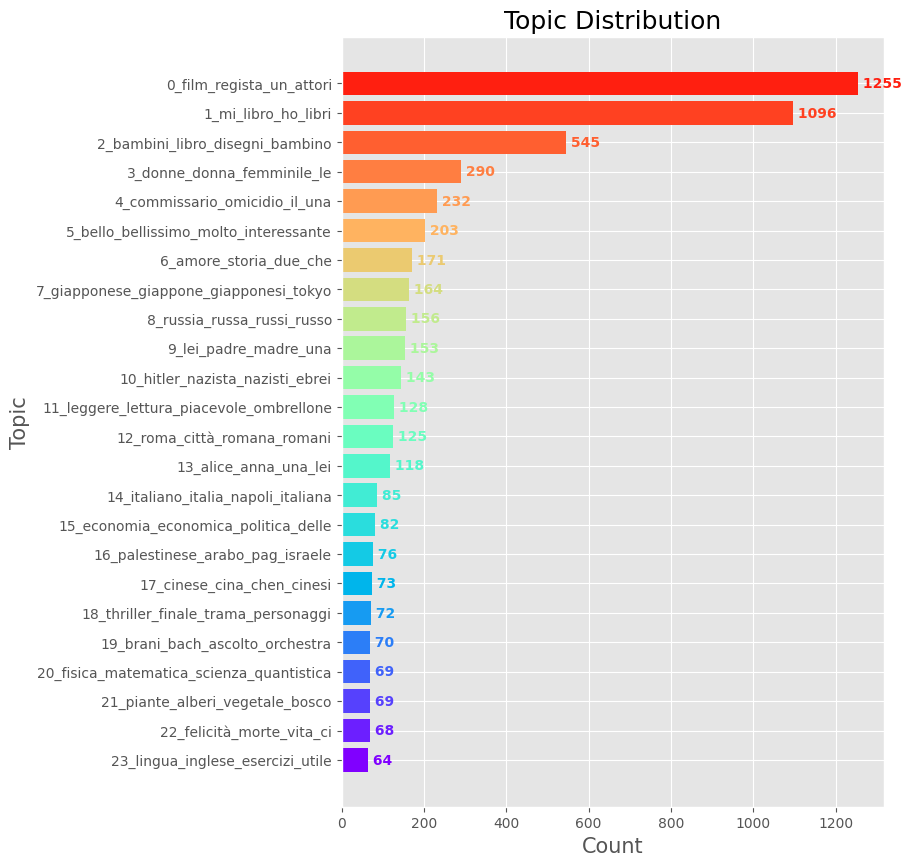

In [21]:
fig = plt.figure(figsize=(7,10))

plt.barh('Name', 'Count',
         data=topics_pivot.head(top_topics).drop([0]).sort_values('Count',ascending=True), color=colors)
plt.xlabel("Count", size=15)
plt.ylabel("Topic", size=15)
plt.title("Topic Distribution", size=18)

# to visualize the count of topics at the end of the bar
for i, v in enumerate(topics_pivot.head(top_topics).drop([0])["Count"].sort_values(ascending=True)):
    c = next(iter_color)
    plt.text(v, i, " "+str(v), color=c, va='center', fontweight='bold')

In [22]:
df['topics'] = topics
df.head(3)

Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0                           4          138                 4.0000   
1                        None         3567                   None   
2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

   Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0           31    STUDENTE                  1990  00148  Libro moderno   
1           33    STUDENTE                  1982  04011  Libro moderno   
2           33    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  topics  
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23     130  
1                              Testi rari e preziosi    2018/08/28      -1  
2                   "Genuflesse finanche le parole"     2018/08/31      -1

In [23]:
'''
We perform sentiment analysis over the readers reviews to determine whether a comment is positive or negative by using the feel-it-italian-sentiment⁸ model, available on HuggingFace⁹.

The model fine-tuned the UmBERTo¹⁰ model on a new dataset: FEEL-IT, a novel benchmark corpus of Italian Twitter posts.
'''

'\nWe perform sentiment analysis over the readers reviews to determine whether a comment is positive or negative by using the feel-it-italian-sentiment⁸ model, available on HuggingFace⁹.\n\nThe model fine-tuned the UmBERTo¹⁰ model on a new dataset: FEEL-IT, a novel benchmark corpus of Italian Twitter posts.\n'

In [24]:
# From: https://huggingface.co/MilaNLProc/feel-it-italian-sentiment
# Sentiment Analysis

# to load the tokenizer associated with the model. A tokenizer is responsible for preparing the inputs for a model
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")

# to load the pre-trained model. This model can be used for tasks like sentiment analysis or emotion classification
model_sentiment = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt") # It tokenizes the input text and prepares it for the model.
# In PyTorch, squeeze() and unsqueeze() are used to adjust the dimensions of a tensor, adding or removing dimension of size 1
    labels = torch.tensor([1]).unsqueeze(0) # It creates a tensor for the labels. In this case, it seems like you’re always using a label of 1, which might correspond to a “positive” sentiment.
    outputs = model_sentiment(**inputs, labels=labels) # It feeds the inputs and labels to the model, which returns the loss and logits.
    loss, logits = outputs[:2]
    logits = logits.squeeze(0)

    proba = torch.nn.functional.softmax(logits, dim=0) # It applies the softmax function to the logits to get probabilities.
    value, index = torch.topk(proba,1) # It uses torch.topk to get the highest probability and its index.

# Depending on the index, it either returns the highest probability (if the index is 1) or 1 minus the highest probability (if the index is not 1). This is based on the assumption that you’re dealing with binary classification (positive vs negative sentiment), and that the probabilities of both classes sum up to 1.
    # class = "Positive" if np.round(index.item()) == 1 else "Negative" 
    # binary classification: P(negative) = 1 - P(positive)
    p = np.round(value.item(), decimals=4) if np.round(index.item()) == 1 else np.round((1-value.item()), decimals=4)

    return p

In [25]:
# We can test the model output on few sentences:

p = predict_sentiment("libro non male ma sconsigliato ad un pubblico maturo")

print("Example: 'libro non male ma sconsigliato ad un pubblico maturo' (The book is not bad, but I would not recommend it to a mature audience)")
print("Sentiment: ", "Positive" if round(p)==1 else "Negative")
print("P(Positive): ", str(p))
print()

p = predict_sentiment("non ricordo l ultimo libro così bello da non farmi dormire la notte")

print("Example: 'non ricordo l ultimo libro così bello da non farmi dormire la notte' (I do not remember such a wonderful book to keep me awake at night)")
print("Sentiment: ", "Positive" if round(p)==1 else "Negative")
print("P(Positive): ", str(p))
print()

p = predict_sentiment("non ho tante idee da menzionare in questo commento, non so se lo faró")

print("Example: 'non ho tante idee da menzionare in questo commento, non so se lo faró")
print("Sentiment: ", "Positive" if round(p)==1 else "Negative")
print("P(Positive): ", str(p))

Example: 'libro non male ma sconsigliato ad un pubblico maturo' (The book is not bad, but I would not recommend it to a mature audience)
Sentiment:  Negative
P(Positive):  0.0009

Example: 'non ricordo l ultimo libro così bello da non farmi dormire la notte' (I do not remember such a wonderful book to keep me awake at night)
Sentiment:  Positive
P(Positive):  0.9998

Example: 'non ho tante idee da menzionare in questo commento, non so se lo faró
Sentiment:  Positive
P(Positive):  0.9997


In [26]:
# In many cases, the sentiment of a text can be determined from the first few words or sentences, and including more words might not significantly improve the accuracy of the sentiment prediction. By limiting the input to the first 30 words, the code can run faster and use less memory, which can be important when processing large datasets.

# word separator (space)
sep = ' '

# max number of words from each comment
# to be used for sentiment analysis
max_w = 30

# create new df column with P(Positive)
df["sentiment"] = [predict_sentiment(sep.join(i.split()[:max_w])) for i in comments]
df.head(3)

Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0                           4          138                 4.0000   
1                        None         3567                   None   
2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

   Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0           31    STUDENTE                  1990  00148  Libro moderno   
1           33    STUDENTE                  1982  04011  Libro moderno   
2           33    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  topics  \
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23     130   
1                              Testi rari e preziosi    2018/08/28      -1   
2                   "Genuflesse finanche le parole"     2018/08/31      -1   

   sentiment  
0     0.9880  
1     0.9997  
2     0.9997

StopIteration: 

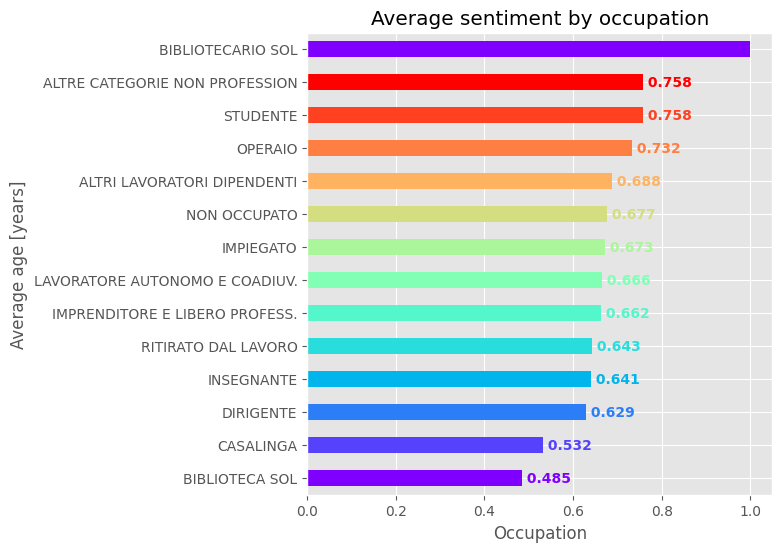

In [27]:
# average sentiment by readers occupation

colors = plt.cm.rainbow(np.linspace(0, 1, 13))
iter_color = iter(colors)

df.groupby("Tipo utente")["sentiment"].mean().sort_values(ascending=True).plot.barh(title="Average sentiment by occupation",
                                                                                    xlabel="Occupation",
                                                                                    ylabel="Average age [years]",
                                                                                    color=colors,
                                                                                    figsize=(6,6))

for i, v in enumerate(df.groupby("Tipo utente")["sentiment"].mean().sort_values(ascending=True)):
  c = next(iter_color)
  plt.text(v, i, " "+str(round(v,3)), color=c, va='center', fontweight='bold')


In [ ]:
'''
We now perform customers’ clustering based on their characteristics (age and occupation) in order to later implement recommendations in absence of preferred topics or interests.
'''

In [28]:

# imputing missing ages with their mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# fitting the imputation model
imp.fit(df[["Eta' utente"]])

# applying the model
imputations = pd.Series(imp.transform(df[["Eta' utente"]]).flatten())
imputations


0        31.0
1        33.0
2        33.0
3        33.0
4        43.0
         ... 
18900    69.0
18901    60.0
18902    47.0
18903    60.0
18904    47.0
Length: 18905, dtype: float64

In [29]:
imputations.value_counts()

63.0    979
60.0    952
47.0    865
53.0    767
33.0    655
       ... 
80.0      4
86.0      3
94.0      1
81.0      1
84.0      1
Name: count, Length: 85, dtype: int64

In [30]:
df[["Eta' utente"]].value_counts()

Eta' utente
63             979
60             952
47             865
53             767
46             655
              ... 
80               4
86               3
81               1
84               1
94               1
Name: count, Length: 85, dtype: int64

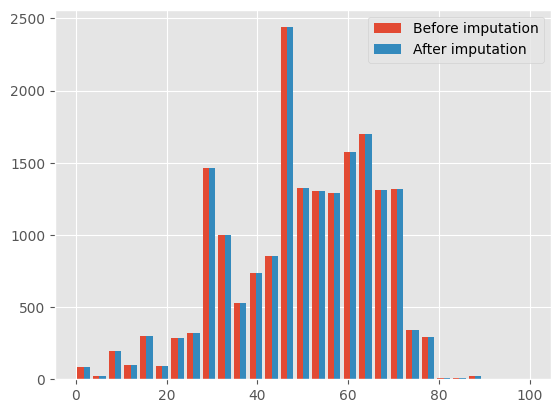

In [31]:
# comparing distributions
bins = np.linspace(0, 100, 30)
plt.hist([df["Eta' utente"], imputations], bins, label=['Before imputation', 'After imputation'])
plt.legend(loc='upper right')
plt.show()

In [32]:
# updating df column with imputed values
df["Eta' utente"] = imputations

In [33]:
# We check whether the age is normally distributed through the Shapiro test:

def isgaussian(data, alpha=0.05):
    stat, p = shapiro(data)
    return True if p > alpha else False


In [34]:
isgaussian(df["Eta' utente"])
# False

False

In [ ]:
# # We use the elbow method to determine the number of clusters:

# def plot_elbow(start, end, data):
#     colors = iter(plt.cm.rainbow(np.linspace(0, 1, end+1-start)))
#     n_clus = list(range(start, end+1))
#     costs = []

#     plt.figure(figsize=(15, 7))

#     for k in n_clus:
#         c = next(colors)
#         model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
#         model.fit_predict(data, categorical=[1])
#         costs.append(model.cost_)

#         plt.plot(k,
#                 model.cost_,
#                 color=c,
#                 label='n° clusters: {}'.format(k),
#                 marker='o',
#                 markersize=12,
#                 markeredgecolor='black',
#                 markeredgewidth=2)

#     plt.plot(n_clus, costs, 'k--')
#     plt.xlabel('N° of clusters')
#     plt.ylabel('Cost')
#     plt.title('Elbow curve')


In [ ]:
# plot_elbow(2, 15, df[["Eta' utente","Tipo utente"]])

In [130]:
df[["Eta' utente","Tipo utente"]]

Eta' utente                  Tipo utente
0             31.0                     STUDENTE
1             33.0                     STUDENTE
2             33.0                     STUDENTE
3             33.0                     STUDENTE
4             43.0  ALTRI LAVORATORI DIPENDENTI
...            ...                          ...
18900         69.0          RITIRATO DAL LAVORO
18901         60.0                    CASALINGA
18902         47.0                 NON OCCUPATO
18903         60.0                    CASALINGA
18904         47.0                 NON OCCUPATO

[18905 rows x 2 columns]

In [35]:
# fitting model with best number of clusters (4) based on the elbow curve
clus_model = KPrototypes(n_clusters=4, init='Huang', random_state=42)
clusters= clus_model.fit_predict(df[["Eta' utente","Tipo utente"]], categorical=[1])

In [36]:
clusters

array([2, 2, 2, ..., 0, 1, 0], dtype=uint16)

In [37]:
# adding clusters column to the dataframe
df.insert(0, "clusters", clusters, True)
df.head(3)

clusters Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0         2                           4          138                 4.0000   
1         2                        None         3567                   None   
2         2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

   Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0         31.0    STUDENTE                  1990  00148  Libro moderno   
1         33.0    STUDENTE                  1982  04011  Libro moderno   
2         33.0    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  topics  \
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23     130   
1                              Testi rari e preziosi    2018/08/28      -1   
2                   "Genuflesse finanche le parole"     2018/08/31      -1   

   sentiment  
0     0.9880  
1     0.9997  
2     0.9997

In [38]:
# We can now inspect the obtained clusters, by observing the age distribution and the most recurrent (and the second most recurrent) occupations within each cluster:

pd.set_option('display.max_colwidth', None)

df.groupby(['clusters'])[["Eta' utente", "Tipo utente"]].agg({"Eta' utente" : ['count', 
                                                                               'mean',
                                                                               'std',
                                                                               'min',
                                                                               'max'], 
                                                              'Tipo utente' : [lambda x: str(x.value_counts().to_frame().iloc[[0]]).replace("count\nTipo utente", "").replace("\n", "") + " (" + str(round(x.value_counts().to_frame().iloc[0][0]*100/ x.count(), 2)) + '%)',
                                                                               lambda x: str(x.value_counts().to_frame().iloc[[1]]).replace("count\nTipo utente", "").replace("\n", "") + " (" + str(round(x.value_counts().to_frame().iloc[1][0]*100/ x.count(), 2)) + '%)'                                                                        
                                                                               ]})

Eta' utente                                   \
               count       mean       std   min   max   
clusters                                                
0               6681  49.194133  4.140519  41.0  57.0   
1               7143  65.534509  5.260203  58.0  94.0   
2               4058  32.356087  4.086942  24.0  41.0   
3               1023  14.015640  6.458641   0.0  23.0   

                                                                     Tipo utente  \
                                                                      <lambda_0>   
clusters                                                                           
0                                                    IMPIEGATO     3930 (58.82%)   
1                                             RITIRATO DAL LAVORO   2064 (28.9%)   
2                                                    STUDENTE      2611 (64.34%)   
3                                                    STUDENTE       879 (85.92%)   

                                                                   
                                                       <lambda_1>  
clusters                                                           
0                                     NON OCCUPATO    835 (12.5%)  
1                                      IMPIEGATO     1693 (23.7%)  
2                                     IMPIEGATO      415 (10.23%)  
3                                   BIBLIOTECA SOL     82 (8.02%)

In [39]:
df.groupby(['Tipo utente'])["clusters"].value_counts()

Tipo utente                     clusters
ALTRE CATEGORIE NON PROFESSION  2             74
                                1             39
                                3             22
                                0             13
ALTRI LAVORATORI DIPENDENTI     0            640
                                2            246
                                1            193
                                3              5
BIBLIOTECA SOL                  3             82
BIBLIOTECARIO SOL               2              1
                                3              1
CASALINGA                       1            888
                                2             48
                                0             45
DIRIGENTE                       1            507
                                0             54
IMPIEGATO                       0           3930
                                1           1693
                                2            415
                            

In [40]:
df.groupby(['Tipo utente'])["clusters"].value_counts().unstack(fill_value=0)

clusters                           0     1     2    3
Tipo utente                                          
ALTRE CATEGORIE NON PROFESSION    13    39    74   22
ALTRI LAVORATORI DIPENDENTI      640   193   246    5
BIBLIOTECA SOL                     0     0     0   82
BIBLIOTECARIO SOL                  0     0     1    1
CASALINGA                         45   888    48    0
DIRIGENTE                         54   507     0    0
IMPIEGATO                       3930  1693   415   16
IMPRENDITORE E LIBERO PROFESS.   624  1633   154    0
INSEGNANTE                         3     0    95    0
LAVORATORE AUTONOMO E COADIUV.   366    27   248    0
NON OCCUPATO                     835    97   130   17
OPERAIO                           13     2    36    1
RITIRATO DAL LAVORO                1  2064     0    0
STUDENTE                         157     0  2611  879

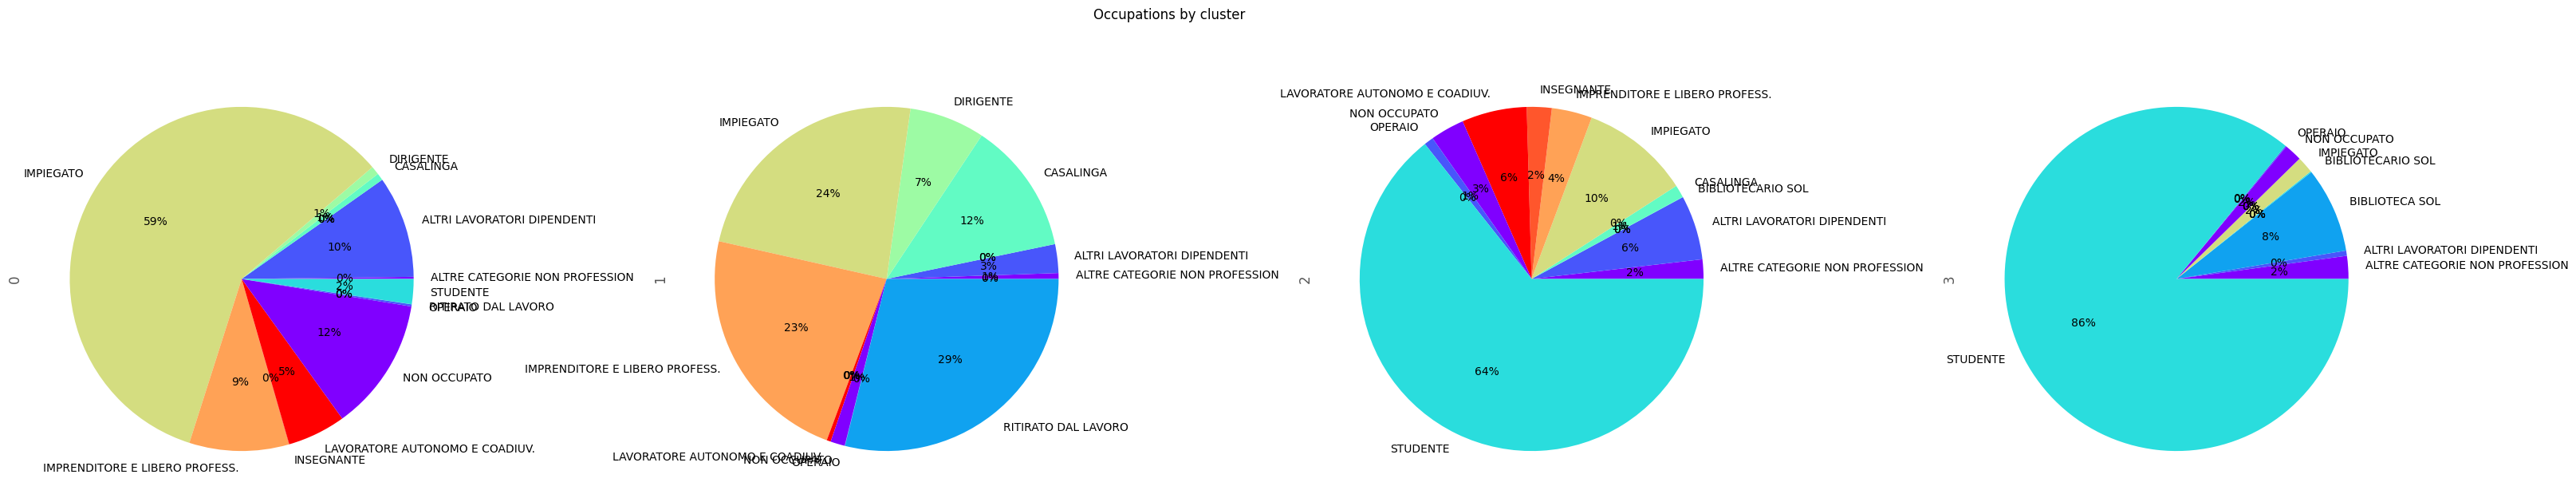

In [44]:
# The distribution of occupations by cluster can also be visually inspected:


ax = df.groupby(['Tipo utente'])["clusters"].value_counts().unstack(fill_value=0).plot(kind='pie', 
                                                                                       autopct='%1.0f%%',
                                                                                       figsize=(40, 7),
                                                                                       colors = plt.cm.rainbow(np.linspace(0, 1, 10)), 
                                                                                       subplots=True,
                                                                                       legend=False,
                                                                                       title='Occupations by cluster')


In [45]:
#Young students (cluster n°3) manifest the most positive sentiment in reviews, while retirees or emplooyees over 60 (cluster n°1) exhibit the least positive sentiment:

df.groupby(['clusters'])["sentiment"].mean()

clusters
0    0.680459
1    0.611477
2    0.755686
3    0.793106
Name: sentiment, dtype: float64

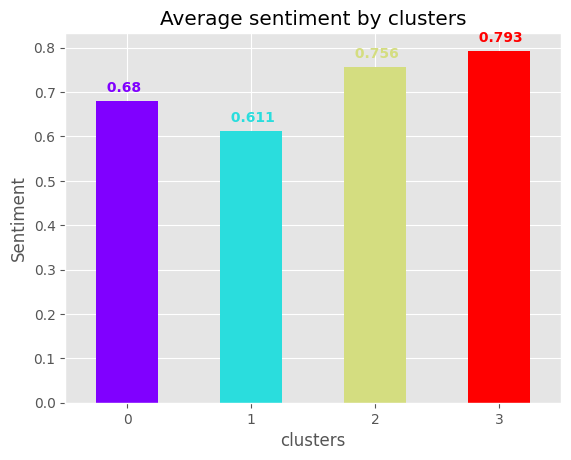

In [46]:
colors = plt.cm.rainbow(np.linspace(0, 1, 4))
iter_color = iter(colors)

df.groupby(['clusters'])["sentiment"].mean().plot.bar(rot=0, 
                                                      title="Average sentiment by clusters", 
                                                      ylabel="Sentiment",
                                                      color=plt.cm.rainbow(np.linspace(0, 1, 4)))

for i, v in enumerate(df.groupby(["clusters"])["sentiment"].mean()):
  c = next(iter_color)
  plt.text(i-0.2, v+0.03, " "+str(round(v,3)), color=c, va='center', fontweight='bold')

In [ ]:
'''
Thanks to topic modeling performed on customers reviews, we may find the most similar topic associated to the argument of interest and then, among that topic, recommend the most positively reviewed titles.

Therefore, we define a Recommendation class that takes the topic model and a search query as input, and provides methods to:

determine the most similar topic,
display its representation (class-based TF-IDF words scores) through a wordcloud chart, and
recommend the first n titles based on topic similarity and sentiment score:

In [47]:
class Word:
    """Word class: an important concept and its score
        - w [string]: important word in a topic
        - s [double]: score of the word in the topic
    """

    def __init__(self, w, s):
        self.w = w
        self.s = s

    def __repr__(self):
        return '<word: "%s", score: %s>' % (self.w, self.s)

    def __str__(self):
        return '(word: "%s", score: %s)' % (self.w, self.s)
    
    # The __repr__ and __str__ methods are used to control how a Word object is displayed when you print it or convert it to a string. 
    # This can make your code easier to understand and debug
    # print(your_object) or str(your_object) will call your_object.__str__().
    # repr(your_object) or just typing your_object in a console will call your_object.__repr__().

In [54]:
topic_model.find_topics('paura', top_n=1)

([73], [0.57277006])

In [55]:
topics_pivot.iloc[74]

Topic                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       73
Count    

In [56]:
topic_model.get_topic(73)

[('coraggio', 0.056096334754618594),
 ('siamo', 0.029939251035617256),
 ('paure', 0.02861610819232581),
 ('noi', 0.028012591144230565),
 ('quando', 0.026123637563629808),
 ('prende', 0.02550344514244972),
 ('nasce', 0.024799667682796702),
 ('chi', 0.02084850029511381),
 ('fronteggiarle', 0.01971593377483995),
 ('indomabili', 0.01971593377483995)]

In [58]:
[Word(iter[0], iter[1]) for iter in topic_model.get_topic(73)]

[<word: "coraggio", score: 0.056096334754618594>,
 <word: "siamo", score: 0.029939251035617256>,
 <word: "paure", score: 0.02861610819232581>,
 <word: "noi", score: 0.028012591144230565>,
 <word: "quando", score: 0.026123637563629808>,
 <word: "prende", score: 0.02550344514244972>,
 <word: "nasce", score: 0.024799667682796702>,
 <word: "chi", score: 0.02084850029511381>,
 <word: "fronteggiarle", score: 0.01971593377483995>,
 <word: "indomabili", score: 0.01971593377483995>]

In [60]:
type([Word(iter[0], iter[1]) for iter in topic_model.get_topic(73)][0])

__main__.Word

In [62]:
df["topics"].head()

0    130
1     -1
2     -1
3     -1
4     -1
Name: topics, dtype: int64

In [77]:
topic_model.find_topics('paura', top_n=1)[0][0]

73

In [78]:
df["topics"]==topic_model.find_topics('paura', top_n=1)[0][0]

0        False
1        False
2        False
3        False
4        False
         ...  
18900    False
18901    False
18902    False
18903    False
18904    False
Name: topics, Length: 18905, dtype: bool

In [81]:
df.loc[df["topics"]==topic_model.find_topics('paura', top_n=1)[0][0]].head(1)

clusters Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
338         3                        None          840                   None   

    Cod. tipo materiale            Tipo documento Identificativo titolo  \
338                   M  Testo a stampa (moderno)                 26786   

     Eta' utente     Tipo utente Anno di pubblicazione CAP Tipo materiale  \
338          0.0  BIBLIOTECA SOL                  1987      Libro moderno   

    Lingua 3 Lingua 2      Natura  \
338                    Monografia   

                                                                                                                                                                                                                                                                                                             Descrizione commento  \
338  Le paure, come i mostri selvaggi, vanno domate e l’unico modo per farlo è affrontarle, guardarle bene in faccia, negli occhi. Il coraggio non nasce con noi, non è la nostra spavalderia. Fare fronte alle paure, riconoscerle, fronteggiarle, scegliere cosa fare e da che parte stare: è lì che il coraggio prende vita.     

     Lingua 1 Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3  \
338  ITALIANO              BIB           ITA           M                 

    Cod. Lingua 2 Cod. tipo documento  \
338                                LM   

                                                                                                                                         Titolo  \
338  Il *GGG / Roald Dahl ; illustrazioni di Quentin Blake. - Firenze : Salani, [1987]. - 223 p. : ill. ; 19 cm. ((Trad. di Donatella Ziliotto.   

                        Titolo commento Data commento  topics  sentiment  
338  Il coraggio, la paura, fare fronte    2015/04/10      73     0.0003

In [83]:
len(df.loc[df["topics"]==topic_model.find_topics('paura', top_n=1)[0][0]])

25

In [82]:
df.loc[df["topics"]==topic_model.find_topics('paura', top_n=1)[0][0]].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(3)

Titolo  \
13458                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        *Autunno / Ali Smith ; traduzione di Federica Aceto. - Roma : SUR, 2018. - 226 p. ; 22 cm   
14209  The *Greatest showman / directed by  Michael Gracey ; story by Jenny Bicks ; screenpaly by Jenny Bicks, Bill Condon ; director of photography Seamus McGarvey ; songs by Benj Pasek, Justin Paul. - 20th Century Fox, 2018. - 1 DVD-Video (100 min circa) : color. ((Titolo del contenitore. - Caratteristiche tecniche: codice area 2; PAL; 16/9 widescreen version, 2.40:1; Dolby digital 5.1. - Riproduzione del film: Stati Uniti, 2017; interpreti : Hugh Jackman, Zac Efron, Michelle Williams, Rebecca Ferguson. - Lingue e sottotitoli: italiano, inglese. - Contenuti speciali: il Karaoke, l'instancabile gruppo dietro The Greatest showman, lo spettacolo, juke-box. - Film per tutti. - Supporto integrativo a testate editoriali.   
2111                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   La *zuppa del coraggio / [Maryann Cocca-Leffler!. - Vicenza : Il punto d'incontro, 2003. - [16! c. : in gran parte ill. ; 23x28 cm. ((Trad. di Ilaria Dal Brun.   

       sentiment  
13458     0.9998  
14209     0.9998  
2111      0.9998

In [88]:
# dict(self.words_score)
dict(topic_model.get_topic(topic_model.find_topics('paura', top_n=1)[0][0]))

{'coraggio': 0.056096334754618594,
 'siamo': 0.029939251035617256,
 'paure': 0.02861610819232581,
 'noi': 0.028012591144230565,
 'quando': 0.026123637563629808,
 'prende': 0.02550344514244972,
 'nasce': 0.024799667682796702,
 'chi': 0.02084850029511381,
 'fronteggiarle': 0.01971593377483995,
 'indomabili': 0.01971593377483995}

In [89]:
class Recommendation():
    """Recommendation class: 
        - inputs:
            - topic_model: BERTopic model
            - input concept (str): word from which to perform suggestions
        - vars:
            - t_id [int]: most similar topic id
            - sim [double]: similarity score
        - methods:
            - get_words: list of important words for the most similar topic
    """

    def __init__(self, input, topic_model):
        sim_topics, similarity = topic_model.find_topics(input, top_n=1)
        self.topic_id = sim_topics[0]
        self.similarity = similarity[0]
        self.words_score = topic_model.get_topic(self.topic_id)

    def __repr__(self):
        return '<topic_id: "%s", similarity: %s>' % (self.topic_id, self.similarity)

    def __str__(self):
        return '(topic_id: "%s", similarity: %s)' % (self.topic_id, self.similarity)

    def get_words(self):
        return [Word(iter[0], iter[1]) for iter in self.words_score]
    
    def get_titles(self, n):
        """get_titles: recommends books by users comment topic similarity and sentiment
        - inputs: 
            - n: number of books to recommend 
        - output:
            - df with ordered first n books (2 columns: Titolo, sentiment) 
        """
        return df.loc[df["topics"]==self.topic_id].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(n)

    def get_wordcloud(self):
        """get_wordcloud: plots word cloud for the topic id
        Class-based TF-IDF scores are used instead of word frequencies (BERTopic)
        """
        wc = WordCloud().generate_from_frequencies(dict(self.words_score))
        plt.figure(figsize=(10, 8), dpi=80)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [91]:
topic_model

In [115]:

r = Recommendation("odio", topic_model)

print(r)

(topic_id: "58", similarity: 0.42149675)


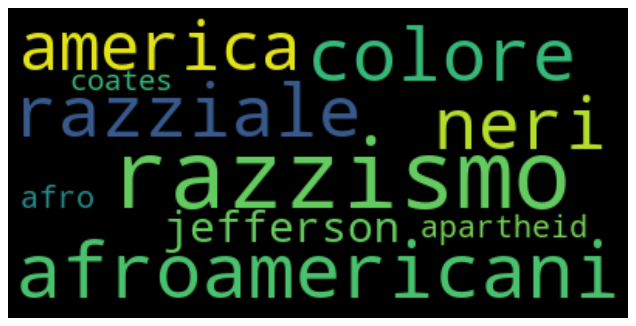

In [116]:
r.get_wordcloud()

In [117]:
# the top five topics, for better book title visualization
pd.set_option("display.max_colwidth", None)

r.get_titles(5)

Titolo  \
8758                                                        Il *buio oltre la siepe / Harper Lee ; traduzione di Amalia D'Agostino Schanzer. - 40. ed. - Milano : Feltrinelli, 2013. - 290 p. ; 20 cm   
6944                                                               The *help /  Kathryn Stockett ;  traduzione di Adriana Colombo e Paola Frezza Pavese. - Milano : Mondadori, 2012. - 524 p. ; 23 cm   
13234                                                                 *Negroland / Margo Jefferson. - [Roma] : 66thand2nd, 2017. - 256 p. : ill. ; 21 cm. ((Traduzione dall'inglese di Sara Antonelli   
9260                                                                               *Americanah / Chimamanda Ngozi Adichie ; traduzione di Andrea Sirotti. - Torino : Einaudi, 2014. - 458 p. ; 22 cm.   
4848   *Amatissima / Toni Morrison ; traduzione di Giuseppe Natale ; postfazione e cura di Franca Cavagnoli ; con un saggio di Alessandro Portelli. - Milano : Frassinelli, [2009]. - 406 p. ; 22 cm.   

       sentiment  
8758      0.9998  
6944      0.9998  
13234     0.9998  
9260      0.9998  
4848      0.9998

(topic_id: "75", similarity: 0.6875735)


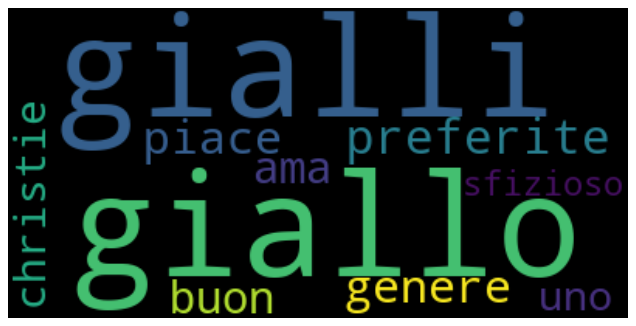

Titolo  \
910    *Dieci piccoli indiani / Agatha Christie ; traduzione di Beata Della Frattina. - Milano : A. Mondadori, 1988. - XVI, 209 p. ; 20 cm.   
6900      *Dieci piccoli indiani / Agatha Christie ; traduzione di Beata Della Frattina. - Milano : Oscar Mondadori, 2011. - 187 p. ; 21 cm   
14772                                                    I *tempi nuovi / Alessandro Robecchi. - Palermo : Sellerio, 2019. - 428 p. ; 17 cm   
13158                La *ragazza che hai sposato / Alafair Burke ; traduzione di Rachele Salerno. - Milano : Piemme, 2018. - 358 p. ; 24 cm   
12743              Il *lato oscuro dell'addio / Michael Connelly ; traduzione di Alfredo Colitto. - Milano : Piemme, 2018. - 368 p. ; 24 cm   

       sentiment  
910       0.9998  
6900      0.9998  
14772     0.9998  
13158     0.9998  
12743     0.9998

In [119]:
r = Recommendation("giallo", topic_model)
print(r)
# display most similar topic representation through a wordcloud chart
r.get_wordcloud()

# return the top 5 titles ordered by descending sentiment score
r.get_titles(5)

(topic_id: "112", similarity: 0.78587306)


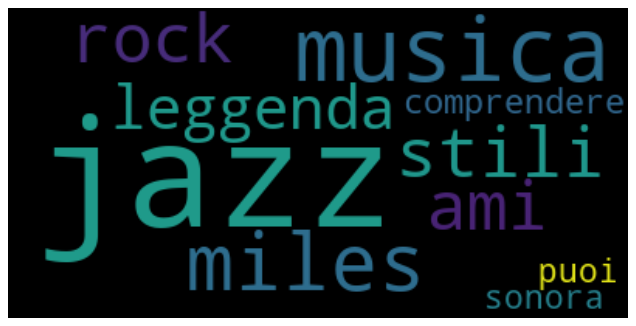

Titolo  \
238                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      La *signora canta il blues / Billie Holiday ; con la collaborazione di William Dufty ; postfazione di Luciano Federighi ; traduzione di Mario Cantoni. - 2. ed. - Milano : Feltrinelli, 1996. - 296 p. ; 20 cm. ((Ed. precedente pubblicata con il titolo: La signora canta i blues   
5700                                                                                                                                                                                                                                                                                                                                                                                                                                                                        *Abbiamo tutti un blues da piangere [Audioregistrazione] / Perigeo. - RCA, [1989?], p1973. - 1 compact disc (44 min. 05 sec.) : AAD, stereo. ((Incluso fasc. programma. - Contiene: Non c'è tempo da perdere ; Deja vu ; Rituale ; Abbiamo tutti un blues da piangere ; Country ; Nadir ; Vento, pioggia e sole.   
8286                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               *Davis, C.: Understudy (The) (Carewe, London Studio Band). - Hong Kong : Naxos Digital Services Us Inc. - Registrazioni sonore musicali. ((Modalità di accesso: streaming   
11821                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 *Jazz. Storie di eroi / Luigi Cancedda. - [S.l.] : Logus, 2013. - 1 testo elettronico (EPUB) (970 KB)    
12138  *La La Land / scritto e diretto da Damien Chazelle ; testi di Benj Pasek & Justin Paul ; direttore della fotografia Linus Sandgren ; musiche di Justin Hurwitz ; scenografie di David Wasco. - 01 Distribution, 2017. - 1 DVD-Video (circa 123 min) : colore. ((Titolo del contenitore. - Caratteristiche tecniche: codice area 2; PAL; 2,55:1, 16/9 widescreen; Dolby digital 5.1, italiano anche dts. - DVD-9. - Riproduzione del film: Stati Uniti, 2016; interpreti: Ryan Gosling, Emma Stone, John Legend, Rosemarie DeWitt; vincitore di 6 premi Oscar. - Lingue: italiano, inglese; sottotitoli: italiano per non udenti. - Contenuti speciali: trailer italiano, girando nel traffico, il party, design. - Film per tutti. - Anche supporto integrativo a testate editoriali.   

       sentiment  
238       0.9998  
5700      0.9998  
8286      0.9998  
11821     0.9998  
12138     0.9998

In [120]:
r = Recommendation("jazz", topic_model)
print(r)
# display most similar topic representation through a wordcloud chart
r.get_wordcloud()

# return the top 5 titles ordered by descending sentiment score
r.get_titles(5)

(topic_id: "18", similarity: 0.5220314)


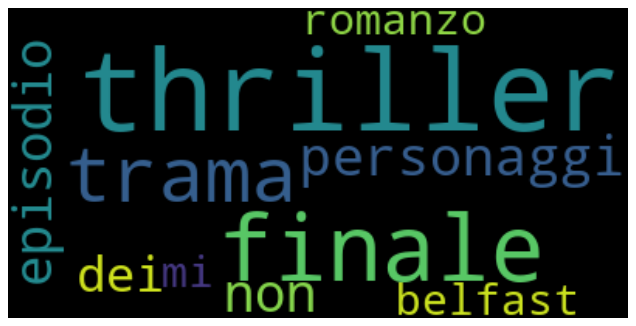

Titolo  \
13289                                                                          *Sara al tramonto / Maurizio De Giovanni. - Milano : Rizzoli, 2018. - 359 p. ; 22 cm   
14490  *Bianco letale : romanzo / Robert Galbraith [i.e. J. K. Rowling] ; traduzione di Valentina Daniele ... [et al.]. - [Milano] : Salani, 2019. - 782 p. ; 21 cm   
14166                                         L'*uomo duplicato / José Saramago ; traduzione di Rita Desti. - 4. ed. - Milano : Feltrinelli, 2018. - 270 p. ; 20 cm   
8543             La *vendetta veste Prada : il ritorno del diavolo / Lauren Weisberger ; traduzione di Valentina Daniele. - Milano : Piemme, 2013. - 447 p. ; 22 cm   
16597       *Anime trasparenti : Un'indagine dell'ispettore Miranda / Daniele Bresciani. - [S.l.] : Garzanti, 2020. - 1 testo elettronico (EPUB) (396 p., 0.63 MB)    

       sentiment  
13289     0.9998  
14490     0.9998  
14166     0.9998  
8543      0.9998  
16597     0.9998

In [123]:
r = Recommendation("horror", topic_model)
print(r)
# display most similar topic representation through a wordcloud chart
r.get_wordcloud()

# return the top 5 titles ordered by descending sentiment score
r.get_titles(5)

In [ ]:
'''
Recommendation by customers characteristics
In a scenario in which a user has no preferred topics or specific interests, and no search/loan history is available, recommendations may be still achieved by exploiting the customer segments produced by clustering.

Given a user’s age and occupation, we could find its cluster of belonging, and return the most positively reviewed titles in that cluster as recommendations:
'''

In [132]:
# clus_model.predict(33,'STUDENTE') 
obj_inp = pd.DataFrame({"Eta' utente": 33, "Tipo utente": 'STUDENTE'}, index=[0])
obj_inp

Eta' utente Tipo utente
0           33    STUDENTE

In [133]:
clus_model.predict(obj_inp, categorical=[1])

array([2], dtype=uint16)

In [135]:
df.loc[df["clusters"]==2].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(5)

Titolo  \
14694                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                *Oggi è il giorno giusto per dare una svolta alla tua vita : [romanzo] / Raphaëlle Giordano ; traduzione di Sara Arena. - Milano : Garzanti, 2019. - 358 p. ; 22 cm.   
6551   *Ex [Videoregistrazione] / regia Fausto Brizzi ; soggetto e sceneggiatura Fausto Brizzi, Marco Martani, Massimiliano Bruno ; musiche originali Bruno Zambrini. - 01 Distribution, [2009]. - 1 DVD (ca. 110 min.)  : color. ((Tit. del contenitore. - Caratteristiche tecniche: codice area 2; PAL, 2.35:1 panoramico, 16:9 anamorfico; Dolby digital 5.1 DTS. - DVD-9. - Ripr. del film: Italia, 2008; interpreti: Claudio Bisio, Nancy Brilli, Cristiana Capotondi, Cécile Cassel, Fabio De Luigi, Alessandro Gassman, Claudia Gerini, Flavio Insinna,  Silvio Orlando, Vincenzo Salemme, Gianmarco Tognazzi, Martina Pinto, Carla Signoris, Giorgia Wurth, Malik Zidi, Vincenzo Salemme, Elena Sofia Ricci. - Sottotitoli: italiano per non udenti; inglese. - Data di pubblicazione da repertori on-line. - Contenuti speciali: scene estese, scene eliminate, foto, trailer. - Film per tutti.   
6659                                                                                                                                                                                                                                                                             *Avatar [Videoregistrazione] / written and directed by James Cameron ; director of photography Mauro Fiore ; music by James Horner ; visual effects & animation by Weta Digital. - Twentieth Century Fox Home Entertainment, 2010. - 1 DVD (ca. 162 min.) : color. ((Tit. del contenitore. - Caratteristiche tecniche: codice area 2; PAL; 16:9 full frame version, 1.78 Aspect Ratio; Dolby digital 5.1. - Ripr. del film: Stati Uniti, Gran Bretagna, 2009; interpreti: Sam Worthington, Zoe Saldana, Stephen Lang, Michelle Rodriguez, Sigourney Weaver. - Lingue e sottotitoli: italiano, inglese. - Film per tutti.   
6653                                                                                                                                              Una *moglie bellissima / regia di Leonardo Pieraccioni ; soggetto e sceneggiatura Leonardo Pieraccioni, Giovanni Veronesi ; fotografia Italo Petriccione ; musiche Gianluca Sibaldi. - Medusa Video, 2007. - 1 DVD (93 min.) : color.  ((Tit. del contenitore. - Caratteristiche tecniche: codice area 2; PAL; panoramico, 2.35:1, ottimizzato per tv 16:9; Dolby digital 5.1. - Ripr. del film: Italia, 2007; interpreti: Leonardo Pieraccioni, Laura Torrisi, Gabriel Garko, Massimo Ceccherini, Rocco Papaleo, Francesco Guccini, Tony Sperandeo. - Lingue: italiano; sottotitoli: italiano per non udenti, inglese. - Contenuti speciali: interviste a Leonardo Pieraccioni, Laura Torrisi e cast,scene tagliate, papere, teaser. - Film per tutti.   
14358                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [136]:
class Reader:
    """Reader class:
        - inputs:
          - age [int]: age in years
          - job [double]: reader's profession
        - methods:
          - get_titles_from_reader: recommends books by top sentiment scores within reader cluster
    """

    def __init__(self, age, job):
        self.age = age
        self.job = job
        self.obj = pd.DataFrame({"Eta' utente": self.age, "Tipo utente": self.job}, index=[0])
        self.cluster = clus_model.predict(self.obj, categorical=[1])[0]

    def __repr__(self):
        return '<Reader: age: "%s", job: %s, cluster: %s>' % (self.age, self.job, self.cluster)

    def __str__(self):
        return '(Reader: age: "%s", job: %s, cluster: %s)' % (self.age, self.job, self.cluster)
    
    def get_titles_from_reader(self, n):
        """get_titles_from_reader: recommends books by top sentiment scores within reader cluster
          - inputs: 
            - n: number of books to recommend 
          - output:
            - df with ordered first n books (2 cols: Titolo, sentiment) 
        """
        return df.loc[df["clusters"]==self.cluster].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(n)

In [141]:
new_reader = Reader(age= 62, job='CASALINGA')

new_reader

<Reader: age: "62", job: CASALINGA, cluster: 1>

In [142]:
new_reader.get_titles_from_reader(3)

Titolo  \
18903                              *Spizzichi e bocconi / Erri De Luca ; con interventi di Valerio Galasso. - Milano : Feltrinelli, 2022. - 190 p. : ill. ; 22 cm   
11477  Gli *assalti alle panetterie / Murakami Haruki ; illustrato da Igort ; traduzione di Antonietta Pastore. - Torino : Einaudi, 2016. - 57 p. : ill. ; 23 cm.   
4455                                Un *drink prima di uccidere / Dennis Lehane. - Casale Monferrato : Piemme, 2004. - 349 p. ; 22 cm. ((Trad. di Barbara Murgia.   

       sentiment  
18903     0.9998  
11477     0.9998  
4455      0.9998

In [143]:
new_reader = Reader(age= 12, job='STUDENTE')

new_reader.get_titles_from_reader(1)

Titolo  \
11  Il *gabbiano Jonathan Livingston / Richard Bach ; fotografie di Russel Munson ; traduzione di Pier Francesco Paolini. - Milano : Biblioteca universale Rizzoli, 1977. - 102 p. : ill. ; 18 cm.   

    sentiment  
11     0.9998

In [156]:
pd.reset_option('display.max_colwidth')
topics_comm = topics_pivot[topics_pivot.Topic!=-1][['Topic','Name']]
topics_comm['Name'] = topics_comm['Name'].str.replace(r'[0-9_]', ' ', regex=True)
topics_comm

Topic                                    Name
1        0                  film regista un attori
2        1                       mi libro ho libri
3        2           bambini libro disegni bambino
4        3                donne donna femminile le
5        4             commissario omicidio il una
..     ...                                     ...
154    153           venezia città veneziano acqua
155    154            destino lajos ester scappare
156    155             guerra soldati nemico paura
157    156           florio sicilia franca bagnara
158    157      shopping kinsella bloomwood sophie

[158 rows x 2 columns]

In [161]:
df_comm = df[df.topics!=-1][['Descrizione commento','topics']]
df_comm.head()

Descrizione commento  topics
0   Libro consigliato a tutti coloro che vogliono ...     130
6   Lessi per la prima volta la trilogia della Fon...      84
9   Il titolo prende spunto da "La secchia rapita"...      49
10  Un bel romanzo un po' triste ma in fondo carin...      14
11             Mi è piaciuto molto.\nLo consiglierei.      64

In [171]:
df_merged = df_comm.merge(topics_comm, left_on='topics', right_on='Topic').drop('topics', axis=1)
df_merged.head()

Descrizione commento  Topic  \
0  Libro consigliato a tutti coloro che vogliono ...    130   
1  Appassionante, anche se ho avuto l'impressione...    130   
2  Antologia che comprende molti dei cantos più n...    130   
3  Letto con interesse. Particolarmente degna di ...    130   
4  Non mi ha appassionato, ma bene che ci sia il ...    130   

                                        Name  
0      traduzione traducibilità testo cantos  
1      traduzione traducibilità testo cantos  
2      traduzione traducibilità testo cantos  
3      traduzione traducibilità testo cantos  
4      traduzione traducibilità testo cantos

In [181]:
df_merged.to_excel(r"G:\My Drive\Ingegneria\Data Science GD\Models\NLP\BERT Multiclass TF\commentstopics.xlsx")